In [1]:
from google.colab import drive
drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd

#df_ner = pd.read_csv("ner.csv", encoding ="cp1252", error_bad_lines=False)
df_ner = pd.read_csv("drive/My Drive/Colab Notebooks/T2 - NN/ner.csv",encoding ="cp1252", error_bad_lines=False)

b'Skipping line 281837: expected 25 fields, saw 34\n'


In [5]:
df_ner.dropna(inplace = True)
dataset = df_ner[["lemma","word","pos","tag","prev-iob"]]
dataset.head(15)


,lemma,word,pos,tag,prev-iob
0,thousand,Thousands,NNS,O,__START1__
1,of,of,IN,O,O
2,demonstr,demonstrators,NNS,O,O
3,have,have,VBP,O,O
4,march,marched,VBN,O,O
5,through,through,IN,O,O
6,london,London,NNP,B-geo,O
7,to,to,TO,O,B-geo
8,protest,protest,VB,O,O
9,the,the,DT,O,O


(A) Se leen los datos del archivos,  almacenando las oraciones encontradas en la sección lemma en la variable dataX_raw, asociando su respectivo *tag* a la variable dataY_raw. No hay mucho más que decir, salvo que el uso del **lemma** en esta situación es debido a que lo que se busca es utilzar el "núcleo" (por así decirlo) de la palabra, ya que el mismo contexto la palabra puede estar conjugada de otra forma pero signifcar lo mismo. De no hacerlo de esta manera, estaríamos considerando 2 (o más) palabras como distintas cuando en realidad son iguales. 

In [0]:
#(A) Se almacenan las oraciones encontras en la lista dataX_raw, asociando su output con su respectivo tag.

n_used = 500000 #data to use-- your choice
dataX_raw,dataY_raw = [],[]
lemmas,labels = set(), set()  #uniques
sentence= list(dataset['lemma'])
labels_sentence=list(dataset['tag'])
for fila in dataset.values[:n_used]:
    if fila[-1]=="__START1__": 
        dataX_raw.append(sentence)
        dataY_raw.append(labels_sentence)
        sentence = []
        labels_sentence = []
    lemmas.add(fila[0])
    labels.add(fila[3])
    sentence.append(fila[0]) #add lemma
    labels_sentence.append(fila[3]) #TAG
dataX_raw = dataX_raw[1:]
dataY_raw = dataY_raw[1:]

(B) Visualizamos los datos y destacamos varias cosas. Primero,  que la oración más larga posee 70 palabras (esto será de utilidad para más adelante).
Segundo, utilizamos un contador para estudiar la frecuencia con la que aparecen las palabras en el archivo. Con ello se graficó su distribución (ver gráfico más abajo) y se comparó con el gráfico de **1/n^a**, donde **a** es un número poco mayor que 1. 
Lo anterior se realizó con el objetivo de ver si la distribución de las palabras cumplía la **Ley Zipf**. En base a los dos último gráficos de esta sección es posible ver el diccionario con el que trabajamos sí se distribuye y cumple la ley zipf.

Un tema importante a tener en cuenta es la cantidad de veces que aparece que aparece la palabra **the** dentro de nuestra muestra (ver variable *datos*) y es que aparece 30585 (equivalente al 6% total de la muestra). Más abajo se hablará de cómo las palabras con *tag* = O pueden alterar los resultados de nuestra red.

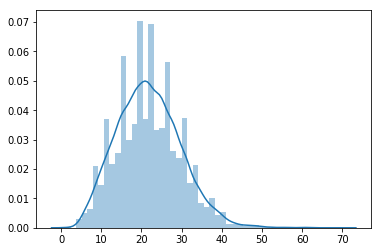

In [0]:
#(B) Visualizamos su distribución y, más abajo, se plotea la frecuencia con la que aparecen las palabras. Contrastando el gráfico con el 
#el de 1/n^a es posible ver que sí cumple la Ley Zipf

import matplotlib.pyplot as plt
import seaborn as sns

largo_textos=[]
for largo in dataX_raw:
    largo_textos.append(len(largo))
    
    
sns.distplot(largo_textos)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in true_divide
  


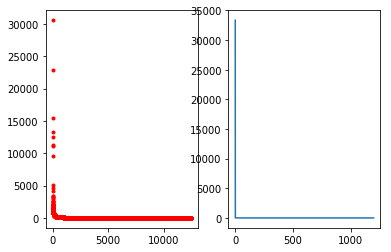

In [0]:
from collections import Counter

cnt = Counter()
for word in dataset.values[:n_used]:
    cnt[word[0]]+=1


freq = dict(cnt)
ca = sorted(freq.values(), reverse=True)
cb = sorted(freq, key=lambda k: freq[k], reverse=True)
datos = pd.DataFrame([cb,ca], index = ['Palabra', 'Frecuencia']).T

def f(n):
    return 1/n
intervalo = np.arange(0, 1200, 0.00003)


plt.figure(1)
plt.subplot(121)
plt.plot(list(datos['Frecuencia'].values), 'r.')

plt.subplot(122)
plt.plot(intervalo,f(intervalo))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


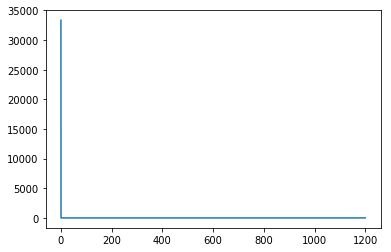

In [0]:
def f(n):
    return 1/n
intervalo = np.arange(0, 1200, 0.00003)

plt.plot(intervalo, f(intervalo))

    

En el gráfico de abajo se puede apreciar que los tag's no están distribuidos uniformemente (al igual que las palabras) y es que el tag 'O' sobresale de los anteriores (correspondiente al 84% de la muestra). Es por eso que al momento de evaluar el modelo, se hará entre los demás tag y no los tags 'O'. Esto, ya que es el más común, por lo tanto hará que el modelo se vea mejor de lo que es. 

Text(0.5, 323496, 'O = 423496')

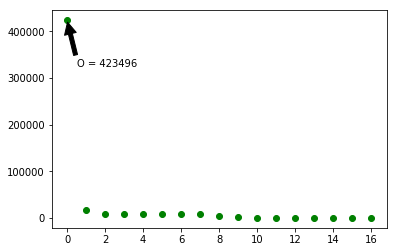

In [0]:
#En el gráfico de abajo se puede apreciar que los tag's no están distribuidos uniformemente (al igual que las palabras) y es que el tag 'O' sobresale 
#de los anteriores. Es por eso que al momento de evaluar el modelo, se hará entre los demás tag y no los tags 'O'. Esto ya que es el más común, hará que el 
#modelo se vea mejor de lo que es. 

cnty = Counter()
for wordy in dataset.values[:n_used]:
    cnty[wordy[3]]+=1

freq_tag = dict(cnty)
cay = sorted(freq_tag.values(), reverse=True)
cby = sorted(freq_tag, key=lambda k: freq_tag[k], reverse=True)
datosy = pd.DataFrame([cby,cay], index = ['Tag', 'Frecuencia']).T
plt.plot(list(datosy['Frecuencia'],),'go')
plt.annotate('O = '+str(datosy['Frecuencia'][0]), xy=(0,datosy['Frecuencia'][0]), xytext = (0.5,datosy['Frecuencia'][0]-100000), arrowprops=dict(facecolor='black', shrink=0.05))

(C) Esta es, sin duda alguna, la parte más importante del trabajo de datos. En lo que sigue, ralizamos una biyección de las palabras a un conjunto de índices (codificar las palabras). Como se dijo anteriormente la ventaja de utilizar los *lemmas* de las palabras radica justamente en esta parte. Y es que, de no ser así estaríamos asociando dos (o más ) índices distintos a palabras que poseen el mismo significado. Por lo tanto al momento de utilizar el w2v (siguiente sección) aparecerán ellas como las palabras más *similares* , dejando fuera palabras cuyo core podría haber aportado mucho más al contexto de la palabra y, con ello, al entrenamiento de la red.


In [0]:
#(C)

cont_lemma = set()
cont_tag = set()
for fila in dataset.values[:n_used]:
        cont_lemma.add(fila[0])
        cont_tag.add(fila[3])
print('existen', len(cont_lemma), 'distintos lemmas y ', len(cont_tag), 'distintos tags')
print('El largo máximo entre todas las oraciones es ', max(largo_textos))    


existen 12450 distintos lemmas y  17 distintos tags
El largo máximo entre todas las oraciones es  70


In [0]:
#Simplemente le asociamos un número a cada palabra y, con ellos, transformamos nuestro data set de oraciones en un data set de números
#(Es simplemente establecer una equivalencia)

idx = {k:i for i,k in enumerate(cont_lemma)}
dataX= [[idx[word] for word in lista] for lista in dataX_raw]


idy = {k : i for i,k in enumerate(cont_tag)}
dataY = [[idy[word] for word in lista] for lista in dataY_raw]

(D) En esta sección se utiliza el largo máximo de los textos. Esto, ya que todas las oraciones están codificadas (debido a que indexamos las palabras), pero poseen todas distintos largos. Por lo tanto, al momento de trabajar con los datos, debemos asegurarnos que esos espacios "vacíos" también sean codificados a traves de una palabra "dummy". En este caso, codificamos la palabra **claritoclarin** la cual será puesta al final de cada oración, haciendo que cada una posea un largo igual a 70 (que fue la oración con más palabras).

In [0]:
#(D)

n_labels = len(cont_tag)
n_lemmas= len(cont_lemma)
max_input_lenght= max(largo_textos)
idx["claritoclarin"] = n_lemmas #add fullfill lemma and tag to the dictionary
idy["claritoclarin"] = n_labels
n_labels +=1
n_lemmas +=1
from keras.preprocessing import sequence
X = sequence.pad_sequences(dataX, maxlen= max_input_lenght,padding='post',value=idx["claritoclarin"])
y = sequence.pad_sequences(dataY, maxlen= max_input_lenght,padding='post',value=idy["claritoclarin"])
#del dataY[:],dataX[:]

Using TensorFlow backend.


(E) En resumen, a las palabras se les da un valor numérico transformándolas en vectores de un dimensiones a definir.
 Con ello, los valores de cada vector serán asignados dependiendo el contexto en el que se encuentre la palabra objetivo
Haciendo que palabras similares, posean valores similares en las entradas de los vectores.
Con la norma L2 es posible calcular la similitud de cada palabra. Esto se ve utilizando el comando most_similar

El hecho de utilizar **min_count=3** sólo nos permite filtrar aquellas palabras que no son tran frecuentes bajo nuetro criterio. En pocas palabras, aquellas palabras que posean frecuencia menor a 3, no serán consideradas. Por eso de los poco más de 12000 lemmas distintos que habían, sólo se leyeron 6957.

In [0]:
#(E) En resumen, a las palabras se les da un valor numérico transformándolas en vectores de un dimensiones a definir.
# Con ello, los valores de cada vector serán asignados dependiendo el contexto en el que se encuentre la palabra objetivo
#Haciendo que palabras similares, posean valores similares en las entradas de los vectores.
#Con la norma L2 es posible calcular la similitud de cada palabra. Esto se ve utilizando el comando most_similar

from gensim.models import Word2Vec
EMBEDDING_DIM = 64   #Cantidad de características que queremos que representen nuestra palabra
window_size = 5     #radio de bola con centro en la palabra de contexto
#window_size = 10
nb_epoch = 5
batch_size = 6000
min_count = 3        #Mínima frecuencia con la que aparece la palabra. Si no la cumple, es eliminada del modelo.
w2v = Word2Vec(dataX_raw,size=EMBEDDING_DIM,window=window_size,batch_words=batch_size,iter=nb_epoch,
                 min_count=min_count, negative=5,sg=1) #sg=1 mean skip-gram
embeddings_index = {vocab_word: w2v.wv[vocab_word] for vocab_word in w2v.wv.vocab}
len(embeddings_index.keys())
print('La cantidad de lemmas leidos es ', len(embeddings_index.keys()))

La cantidad de lemmas leidos es  6957


In [0]:
embedding_matrix = np.zeros((n_lemmas, EMBEDDING_DIM))
for word, i in idx.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: #if word does not has embedding
        embedding_matrix[i] = embedding_vector

In [0]:
from keras.utils import to_categorical
y = np.asarray([to_categorical(i, num_classes=n_labels) for i in y]) #Convertimos los labels en una matriz binaria. En este caso sería de Número oraciones X lemmas x labels

In [0]:
#(F) 

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=22)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state=22)
print('Dimensión datos entrada = ', X_train.shape, '/ Dimensión datos salida = ' ,y_train.shape)

Dimensión datos entrada =  (14656, 70) / Dimensión datos salida =  (14656, 70, 18)


#Acerca de las dimensiones

Por un lado cómo se hizo anteriormente, se hizo que el largo de todas las oraciones fuera igual alargo de la oración más larga (igual a 70).  Es por eso que de las 14656 oraciones son de largo 70 para los datos de entrada. 
Por otro lado, los datos de salida poseen una variable más que vendría siendo la categorización de las palabras. Esto se hizo transformando cada unos de los tags en un *one hot-vector*. Por eso se crea una matriz binaria para cada palabra de la oración. De ahí la nueva dimensión 18 de los datos de salida.

In [0]:
y[0][0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0.], dtype=float32)

A continuación se procederá a entrenar distintas RNN, variando la forma en que utilizan la información (LSTM, GRU, BIDIRECCIONAL), lo parámetros a entrenar y se probará agregar distintas capas, más dropouts, entre otros para ver cuál red es la que obtuvo el mejor desempeño.

Los comentarios de cada modelo se harán al final de ellos para evitar confusiones y, al final del notebook, se hará una comparación entre ellos. 

In [0]:
#(G)
from keras.models import Sequential
from keras.layers import LSTM, Embedding, Dense, Dropout,TimeDistributed
model = Sequential()
model.add(Embedding(input_dim=n_lemmas, output_dim=EMBEDDING_DIM, input_length=max_input_lenght,
                    trainable=False, weights = [embedding_matrix]))
model.add(LSTM(units=100,return_sequences=True))
model.add(Dropout(0.2))
model.add(TimeDistributed(Dense(n_labels, activation='softmax')))
model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=15, batch_size=128)

W0802 13:09:44.521194 140104323704704 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0802 13:09:44.548699 140104323704704 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0802 13:09:44.556794 140104323704704 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0802 13:09:44.577737 140104323704704 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0802 13:09:44.584297 1401043237

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 70, 64)            796864    
_________________________________________________________________
lstm_1 (LSTM)                (None, 70, 100)           66000     
_________________________________________________________________
dropout_1 (Dropout)          (None, 70, 100)           0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 70, 18)            1818      
Total params: 864,682
Trainable params: 67,818
Non-trainable params: 796,864
_________________________________________________________________


W0802 13:09:45.606870 140104323704704 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 14656 samples, validate on 3664 samples
Epoch 1/15
14656/14656 [==============================] - 42s 3ms/step - loss: 0.6221 - val_loss: 0.2566
Epoch 2/15
14656/14656 [==============================] - 22s 1ms/step - loss: 0.2264 - val_loss: 0.1944
Epoch 3/15
14656/14656 [==============================] - 22s 1ms/step - loss: 0.1763 - val_loss: 0.1562
Epoch 4/15
14656/14656 [==============================] - 22s 2ms/step - loss: 0.1469 - val_loss: 0.1344
Epoch 5/15
14656/14656 [==============================] - 22s 1ms/step - loss: 0.1291 - val_loss: 0.1199
Epoch 6/15
14656/14656 [==============================] - 22s 2ms/step - loss: 0.1176 - val_loss: 0.1107
Epoch 7/15
14656/14656 [==============================] - 22s 2ms/step - loss: 0.1099 - val_loss: 0.1047
Epoch 8/15
14656/14656 [==============================] - 22s 1ms/step - loss: 0.1048 - val_loss: 0.1002
Epoch 9/15
14656/14656 [==============================] - 22s 2ms/step - loss: 0.1008 - val_loss: 0.0970
Epoch 

In [0]:
from sklearn.metrics import f1_score

dataY_pred = model.predict_classes(X_test,verbose=0) #process... to remove prediction on "endtagger" symbol
dataY_real = y_test.argmax(axis = 2)

#f1_score_bydata = [f1_score(true, pred ,average='macro') for true,pred in zip(dataY_real,dataY_pred) ]
#print("F1 score on test: ", np.mean(f1_score_bydata) )


from sklearn.metrics import precision_recall_fscore_support

claro = [precision_recall_fscore_support(verdad, predic, average='macro') for verdad,predic in zip(dataY_real, dataY_pred)]
#print(claro)

resum = pd.DataFrame(claro, columns=['precision','recall','f1','support'])
np.mean(resum)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


precision    0.771453
recall       0.771211
f1           0.765764
support           NaN
dtype: float64

In [0]:
from sklearn.metrics import classification_report

mejora_real = []
mejora_pred = []

for p in range(dataY_real.shape[0]):
  mejora_real = mejora_real + [k for k in dataY_real[p]]
  mejora_pred = mejora_pred + [i for i in dataY_pred[p]]

mejora_real = np.array(mejora_real)
mejora_pred = np.array(mejora_pred)

real_labels = mejora_real[mejora_real!=17]
pred_labels = mejora_pred[mejora_real!=17]

pred_labels = pred_labels[real_labels!=idy['O']]
real_labels = real_labels[real_labels!=idy['O']]


indi =sorted(idy.items(), key = lambda x : x[1])
sort_label = np.array(indi)[:,0]

print(classification_report(real_labels,pred_labels,  target_names = sort_label)) #Retirando los O y los claritoclarin de los tags reales de testeo
print(classification_report(mejora_real,mejora_pred,  target_names = sort_label)) #Evaluando el modelo con todo los datos

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


               precision    recall  f1-score   support

        I-eve       0.00      0.00      0.00        48
        I-org       0.79      0.32      0.45      1528
        B-tim       0.96      0.66      0.78      1917
        I-nat       0.00      0.00      0.00        13
        I-per       0.80      0.82      0.81      1675
        B-per       0.88      0.54      0.67      1612
        B-gpe       0.92      0.69      0.79      1620
        I-art       0.00      0.00      0.00        26
        B-org       0.74      0.20      0.31      1943
            O       0.00      0.00      0.00         0
        I-gpe       0.00      0.00      0.00        26
        B-eve       0.00      0.00      0.00        52
        I-geo       0.82      0.46      0.59       731
        B-art       0.00      0.00      0.00        52
        B-nat       0.00      0.00      0.00        23
        I-tim       0.92      0.36      0.52       565
        B-geo       0.79      0.69      0.74      3568
claritocl

#Modelo LSTM sin pesos entrenables

En base a lo anterior, es posible ver que la cantidad de pesos entrenable son 67.818. Esto ya que especificamente pedimos que los pesos de la matriz generada por w2v quedaran intactos (de hecho, basta ver que 796.864 es la dimensión de la matriz). 
Debido a que son pocos pesos, el desempeño de esta red era esperable que fuera "*pobre*" en el sentido de tags más específicos (como aquellos que menos frecuentes eran). Y es que es menos flexibles que las que veremos más adelante. 

Para lo que sigue, se procedió a subestimar el modelo debido a que se eliminaron los tag *O* y *claritoclarin* de los datos de testeo PERO se vio que la red aún así confundió algunos tags con *O* (debido a que, como se dijo anteriormente ellos eran el 84%) y, peor aún, confundió los de la variable dummy.

En un principio se puede observar que considerando todo los datos (es decir, sin remover los O ni claritoclarin) el sistema alcanza a reconocer el 99% de los O disponibles acertándole al 94%. En particular esto hace que la precisión del modelo sea 98%. Lo cual es casi perfecto pero es debido a la gran cantidad de O's que existen, por lo cual es claro que el modelo está **SOBRESTIMADO**, ya que basta notar que no logró identificar ninguna los tag menos frecuentes (nat,eve, art) . Eliminando la cantidad de O de los datos de testeo, se aprecia claramente que el accuracy baja a 55%. Lo cual es más cercano a lo que esperabamos, debido a que el modelo es menos flexible. 

In [0]:
#(H)
from keras.models import Sequential
from keras.layers import LSTM, Embedding, Dense, Dropout,TimeDistributed
model1 = Sequential()
model1.add(Embedding(input_dim=n_lemmas, output_dim=EMBEDDING_DIM, input_length=max_input_lenght,
                    trainable=True, weights = [embedding_matrix]))
model1.add(LSTM(units=100,return_sequences=True))
model1.add(Dropout(0.2))
model1.add(TimeDistributed(Dense(n_labels, activation='softmax')))
model1.summary()
model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model1.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=15, batch_size=128)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 70, 64)            796864    
_________________________________________________________________
lstm_2 (LSTM)                (None, 70, 100)           66000     
_________________________________________________________________
dropout_2 (Dropout)          (None, 70, 100)           0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 70, 18)            1818      
Total params: 864,682
Trainable params: 864,682
Non-trainable params: 0
_________________________________________________________________
Train on 14656 samples, validate on 3664 samples
Epoch 1/15
14656/14656 [==============================] - 26s 2ms/step - loss: 0.6150 - acc: 0.9148 - val_loss: 0.2288 - val_acc: 0.9515
Epoch 2/15
14656/14656 [==============================] - 25s 2ms/step - loss: 0.1

In [0]:

dataY1_pred = model1.predict_classes(X_test,verbose=0) #process... to remove prediction on "endtagger" symbol
dataY1_real = y_test.argmax(axis = 2)

#f1_score_bydata1 = [f1_score(true, pred ,average='macro') for true,pred in zip(dataY1_real,dataY1_pred) ]
#print("F1 score on test: ", np.mean(f1_score_bydata1) )

from sklearn.metrics import precision_recall_fscore_support

claro1 = [precision_recall_fscore_support(verdad, predic, average='macro') for verdad,predic in zip(dataY1_real, dataY1_pred)]
print(claro1)

resum1 = pd.DataFrame(claro1, columns=['precision','recall','f1','support'])
np.mean(resum1)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


[(0.5833333333333333, 0.7307692307692308, 0.615, None), (0.797979797979798, 0.7222222222222223, 0.7016795865633075, None), (1.0, 1.0, 1.0, None), (0.7386363636363636, 0.6136363636363636, 0.6553030303030303, None), (1.0, 1.0, 1.0, None), (1.0, 1.0, 1.0, None), (1.0, 1.0, 1.0, None), (1.0, 1.0, 1.0, None), (1.0, 1.0, 1.0, None), (1.0, 1.0, 1.0, None), (1.0, 1.0, 1.0, None), (1.0, 1.0, 1.0, None), (1.0, 1.0, 1.0, None), (0.7391304347826086, 0.6666666666666666, 0.6818181818181819, None), (0.6470588235294118, 0.6666666666666666, 0.65625, None), (1.0, 1.0, 1.0, None), (0.5505952380952381, 0.6130952380952381, 0.5714285714285714, None), (0.5, 0.5, 0.5, None), (0.7923076923076924, 0.7, 0.7294117647058823, None), (1.0, 1.0, 1.0, None), (1.0, 1.0, 1.0, None), (0.7291666666666666, 0.75, 0.7391304347826086, None), (1.0, 1.0, 1.0, None), (1.0, 1.0, 1.0, None), (0.75, 0.7419354838709677, 0.7459016393442623, None), (0.9933333333333334, 0.9333333333333332, 0.9566101694915254, None), (0.625, 0.495535714

precision    0.871595
recall       0.871956
f1           0.867448
support           NaN
dtype: float64

In [0]:
mejora_real1 = []
mejora_pred1 = []

for p in range(dataY1_real.shape[0]):
  mejora_real1 = mejora_real1 + [k for k in dataY1_real[p]]
  mejora_pred1 = mejora_pred1 + [i for i in dataY1_pred[p]]

mejora_real1 = np.array(mejora_real1)
mejora_pred1 = np.array(mejora_pred1)

real_labels1 = mejora_real1[mejora_real1!=17]
pred_labels1 = mejora_pred1[mejora_real1!=17]

pred_labels1 = pred_labels1[real_labels1!=idy['O']]
real_labels1 = real_labels1[real_labels1!=idy['O']]



print(classification_report(real_labels1,pred_labels1,  target_names = sort_label))
print(classification_report(mejora_real1,mejora_pred1,  target_names = sort_label))

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


               precision    recall  f1-score   support

        I-eve       0.00      0.00      0.00        48
        I-org       0.90      0.70      0.79      1528
        B-tim       0.97      0.85      0.90      1917
        I-nat       0.00      0.00      0.00        13
        I-per       0.90      0.89      0.90      1675
        B-per       0.89      0.84      0.86      1612
        B-gpe       0.95      0.87      0.91      1620
        I-art       0.00      0.00      0.00        26
        B-org       0.82      0.58      0.68      1943
            O       0.00      0.00      0.00         0
        I-gpe       0.00      0.00      0.00        26
        B-eve       1.00      0.08      0.14        52
        I-geo       0.85      0.79      0.82       731
        B-art       0.00      0.00      0.00        52
        B-nat       0.00      0.00      0.00        23
        I-tim       0.87      0.78      0.82       565
        B-geo       0.83      0.88      0.85      3568
claritocl

#**Modelo LSTM con pesos entrenables** 

En este caso, es posible observar que TODOS los atributos están siendo entrenados (864682 atributos). Los cuales son los mismos que el modelo 1 exhibido anteriormente sumado los pesos de la matriz **embedding** generado por w2v. Esto permite que dichos peses se adapten a los entrenamiento ejecutamos por la red. Es de esperar que este modelo funcione mucho mejor que el anterior debido a que es mucho más flexible en cuanto a parámetros respecta. Por otro lado, con el dropout agregado dentro de la red se logró amortiguar considerablemente el overfiting como se puede apreciar arriba. 

Al igual que antes, se exhibe el F1 score para cada uno de los atributos (juntos con su precisión y recall) y se puede observar que el modelo, considerando los tags O, posee un accuracy del 99%. Lo cual parece poco probable debido a que, al igual que antes, no logró identificar la mayoría de los tags poco frecuentes PERO sí identificó algunos como *eve*, lo cual el modelo anterior no pudo. Ello ya es una mejora.
Al momento de remover los tags O del conjunto de testeo, se ve que el accuracy baja a 78%. Lo cual es mucho mejor que el modelo anterior que sólo alcanzó el 55%. 

Era esperable que este modelo en particular mejorará respecto del anterior por lo que se mencionó al principio: Es mucho más flexible. De lo que había que preocuparse era más del overfiting.


In [0]:
#(I)

from keras.models import Sequential
from keras.layers import LSTM, Embedding, Dense, Dropout,TimeDistributed, GRU

model2 = Sequential()
model2.add(Embedding(input_dim=n_lemmas, output_dim=EMBEDDING_DIM, input_length=max_input_lenght,
                    trainable=True, weights = [embedding_matrix]))
model2.add(GRU(units=100,return_sequences=True))
#model2.add(LSTM(units=100,return_sequences=True))
model2.add(Dropout(0.2))
model2.add(TimeDistributed(Dense(n_labels, activation='softmax')))
model2.summary()
model2.compile(loss='categorical_crossentropy', optimizer='adam')
model2.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=15, batch_size=128)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 70, 64)            796864    
_________________________________________________________________
gru_1 (GRU)                  (None, 70, 100)           49500     
_________________________________________________________________
dropout_3 (Dropout)          (None, 70, 100)           0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 70, 18)            1818      
Total params: 848,182
Trainable params: 848,182
Non-trainable params: 0
_________________________________________________________________
Train on 14656 samples, validate on 3664 samples
Epoch 1/15
14656/14656 [==============================] - 22s 1ms/step - loss: 0.7251 - val_loss: 0.1873
Epoch 2/15
14656/14656 [==============================] - 21s 1ms/step - loss: 0.1401 - val_loss: 0.1071
Epoch 3/1

In [0]:
from sklearn.metrics import f1_score
dataY2_pred = model2.predict_classes(X_test,verbose=0) #process... to remove prediction on "endtagger" symbol
dataY2_real = y_test.argmax(axis = 2)

#f1_score_bydata2 = [f1_score(true, pred ,average='macro') for true,pred in zip(dataY2_real,dataY2_pred) ]
#print("F1 score on test: ", np.mean(f1_score_bydata2) )


from sklearn.metrics import precision_recall_fscore_support

claro2 = [precision_recall_fscore_support(verdad, predic, average='macro') for verdad,predic in zip(dataY2_real, dataY2_pred)]
print(claro2)

resum2 = pd.DataFrame(claro2, columns=['precision','recall','f1','support'])
np.mean(resum2)


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


[(0.625, 0.75, 0.6666666666666666, None), (0.7333333333333334, 0.6944444444444443, 0.673015873015873, None), (1.0, 1.0, 1.0, None), (0.9855072463768115, 0.8333333333333334, 0.8814814814814814, None), (1.0, 1.0, 1.0, None), (1.0, 1.0, 1.0, None), (1.0, 1.0, 1.0, None), (1.0, 1.0, 1.0, None), (1.0, 1.0, 1.0, None), (1.0, 1.0, 1.0, None), (1.0, 1.0, 1.0, None), (1.0, 1.0, 1.0, None), (1.0, 1.0, 1.0, None), (0.6141304347826086, 0.625, 0.6193181818181819, None), (0.6470588235294118, 0.6666666666666666, 0.65625, None), (1.0, 1.0, 1.0, None), (0.6190476190476191, 0.6190476190476191, 0.6190476190476191, None), (0.5, 0.5, 0.5, None), (0.8, 0.75, 0.7714285714285715, None), (1.0, 1.0, 1.0, None), (1.0, 1.0, 1.0, None), (0.7291666666666666, 0.75, 0.7391304347826086, None), (1.0, 1.0, 1.0, None), (1.0, 1.0, 1.0, None), (0.75, 0.7419354838709677, 0.7459016393442623, None), (0.9933333333333334, 0.9333333333333332, 0.9566101694915254, None), (0.6428571428571429, 0.5612244897959184, 0.58994708994709, N

precision    0.876270
recall       0.876975
f1           0.872613
support           NaN
dtype: float64

In [0]:
mejora_real2 = []
mejora_pred2 = []

for p in range(dataY2_real.shape[0]):
  mejora_real2 = mejora_real2 + [k for k in dataY2_real[p]]
  mejora_pred2 = mejora_pred2 + [i for i in dataY2_pred[p]]

mejora_real2 = np.array(mejora_real2)
mejora_pred2 = np.array(mejora_pred2)

real_labels2 = mejora_real2[mejora_real2!=17]
pred_labels2 = mejora_pred2[mejora_real2!=17]

pred_labels2 = pred_labels2[real_labels2!=idy['O']]
real_labels2 = real_labels2[real_labels2!=idy['O']]



print(classification_report(real_labels2,pred_labels2,  target_names = sort_label))
print(classification_report(mejora_real2,mejora_pred2,  target_names = sort_label))

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


               precision    recall  f1-score   support

        I-eve       0.00      0.00      0.00        48
        I-org       0.90      0.69      0.78      1528
        B-tim       0.97      0.85      0.91      1917
        I-nat       0.67      0.15      0.25        13
        I-per       0.90      0.90      0.90      1675
        B-per       0.88      0.86      0.87      1612
        B-gpe       0.94      0.88      0.91      1620
        I-art       1.00      0.04      0.07        26
        B-org       0.84      0.58      0.69      1943
            O       0.00      0.00      0.00         0
        I-gpe       1.00      0.19      0.32        26
        B-eve       0.86      0.12      0.20        52
        I-geo       0.85      0.83      0.84       731
        B-art       0.56      0.10      0.16        52
        B-nat       0.50      0.04      0.08        23
        I-tim       0.89      0.76      0.82       565
        B-geo       0.84      0.89      0.86      3568
claritocl

#**Modelo GRU con pesos entrenables** 

Sabemos que la diferencia entre LSTM y GRU no son tan diferentes en términos de desempeño, por lo que en términos de desempeño deberíamos esperar que funcionara similar a los modelos anteriores. Se optó por entrenar la red con los pesos de la matriz embedding entrenables debido a que sabemos que su desempeño será mejor debido a la flexibilidad de éste. (de hecho se testeó el modelo con capa GRU sin pesos entrenables y se obtuvo un acc de 56% para este modelo)

Ahora bien, la red alcanzó un 80% accuracy eliminando los tags O del conjunto de testeo. 
Lo anterior calza con nuestro razonamiento y se ve reflejado en que GRU logró identificar de mejor manera los tags de menor frecuencia (aun así, hubo varios que no logro acertar).

In [0]:
#(J) 


from keras.models import Sequential
from keras.layers import LSTM, Embedding, Dense, Dropout,TimeDistributed, GRU, Bidirectional

gate_layer = GRU(units=100, return_sequences = True)

model3 = Sequential()
model3.add(Embedding(input_dim=n_lemmas, output_dim=EMBEDDING_DIM, input_length=max_input_lenght,
                    trainable=True, weights = [embedding_matrix]))
model3.add(Bidirectional(gate_layer, merge_mode='sum'))
#model3.add(GRU(units=100,return_sequences=True))
#model3.add(LSTM(units=100,return_sequences=True))
model3.add(Dropout(0.2))
model3.add(Dense(100, activation='tanh'))
model3.add(TimeDistributed(Dense(n_labels, activation='softmax')))
model3.summary()
model3.compile(loss='categorical_crossentropy', optimizer='adam')
model3.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=15, batch_size=128)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 70, 64)            796864    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 70, 100)           99000     
_________________________________________________________________
dropout_4 (Dropout)          (None, 70, 100)           0         
_________________________________________________________________
dense_4 (Dense)              (None, 70, 100)           10100     
_________________________________________________________________
time_distributed_4 (TimeDist (None, 70, 18)            1818      
Total params: 907,782
Trainable params: 907,782
Non-trainable params: 0
_________________________________________________________________
Train on 14656 samples, validate on 3664 samples
Epoch 1/15
14656/14656 [==============================] - 44s 3ms/step - loss: 0.5163 -

In [0]:

dataY3_pred = model3.predict_classes(X_test,verbose=0) #process... to remove prediction on "endtagger" symbol
dataY3_real = y_test.argmax(axis = 2)

#f1_score_bydata3 = [f1_score(true, pred ,average='macro') for true,pred in zip(dataY3_real,dataY3_pred) ]
#print("F1 score on test: ", np.mean(f1_score_bydata3) )

from sklearn.metrics import precision_recall_fscore_support

claro3 = [precision_recall_fscore_support(verdad, predic, average='macro') for verdad,predic in zip(dataY3_real, dataY3_pred)]
print(claro3)

resum3 = pd.DataFrame(claro3, columns=['precision','recall','f1','support'])
np.mean(resum3)


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


[(0.625, 0.75, 0.6666666666666666, None), (0.9444444444444445, 0.9444444444444443, 0.9333333333333332, None), (1.0, 1.0, 1.0, None), (1.0, 1.0, 1.0, None), (1.0, 1.0, 1.0, None), (1.0, 1.0, 1.0, None), (1.0, 1.0, 1.0, None), (1.0, 1.0, 1.0, None), (1.0, 1.0, 1.0, None), (1.0, 1.0, 1.0, None), (1.0, 1.0, 1.0, None), (1.0, 1.0, 1.0, None), (1.0, 1.0, 1.0, None), (1.0, 1.0, 1.0, None), (0.6470588235294118, 0.6666666666666666, 0.65625, None), (1.0, 1.0, 1.0, None), (0.48863636363636365, 0.49404761904761907, 0.49127906976744184, None), (0.5, 0.5, 0.5, None), (1.0, 1.0, 1.0, None), (1.0, 1.0, 1.0, None), (1.0, 1.0, 1.0, None), (1.0, 1.0, 1.0, None), (1.0, 1.0, 1.0, None), (1.0, 1.0, 1.0, None), (1.0, 1.0, 1.0, None), (1.0, 1.0, 1.0, None), (0.8333333333333334, 0.75, 0.7777777777777777, None), (1.0, 1.0, 1.0, None), (1.0, 1.0, 1.0, None), (1.0, 1.0, 1.0, None), (1.0, 1.0, 1.0, None), (1.0, 1.0, 1.0, None), (1.0, 1.0, 1.0, None), (1.0, 1.0, 1.0, None), (1.0, 1.0, 1.0, None), (0.666666666666666

precision    0.906200
recall       0.907388
f1           0.903485
support           NaN
dtype: float64

In [0]:
mejora_real3 = []
mejora_pred3 = []

for p in range(dataY_real.shape[0]):
  mejora_real3 = mejora_real3 + [k for k in dataY3_real[p]]
  mejora_pred3 = mejora_pred3 + [i for i in dataY3_pred[p]]

mejora_real3 = np.array(mejora_real3)
mejora_pred3 = np.array(mejora_pred3)

real_labels3 = mejora_real3[mejora_real3!=17]
pred_labels3 = mejora_pred3[mejora_real3!=17]

pred_labels3 = pred_labels3[real_labels3!=idy['O']]
real_labels3 = real_labels3[real_labels3!=idy['O']]


print(classification_report(real_labels3,pred_labels3,  target_names = sort_label))
print(classification_report(mejora_real3,mejora_pred3,  target_names = sort_label))

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


               precision    recall  f1-score   support

        I-eve       0.78      0.38      0.51        48
        I-org       0.91      0.77      0.83      1528
        B-tim       0.98      0.91      0.94      1917
        I-nat       0.50      0.15      0.24        13
        I-per       0.91      0.90      0.91      1675
        B-per       0.89      0.90      0.89      1612
        B-gpe       0.95      0.90      0.92      1620
        I-art       0.67      0.08      0.14        26
        B-org       0.86      0.77      0.81      1943
            O       0.00      0.00      0.00         0
        I-gpe       0.92      0.42      0.58        26
        B-eve       0.89      0.33      0.48        52
        I-geo       0.86      0.83      0.85       731
        B-art       0.80      0.23      0.36        52
        B-nat       0.60      0.13      0.21        23
        I-tim       0.92      0.83      0.87       565
        B-geo       0.89      0.90      0.90      3568
claritocl

#**Modelo Bidireccional con puerta GRU** 

Sin duda alguna, esperabamos que este sea el mejor de los modelos en cuanto a desempeño se habla (ya que el tiempo de ejecución fue bastante mayor). Lo anterior, debido a que con la capa bidireccional, no solamente se puede estudiar el contexto a través de los inputs anteriores, si no que también utilizando los inputs futuros. Ello nos da gran ventaja y precisión en cuanto al tipo de tag que puede tener la palabra. Un resultado claro de lo anterior dicho es que ella logró identificar algunos de los tags de baja frecuencia (cosa que ninguna de las otras redes pudo) y logró mejorar rotundamente la identificación de la posición del *chunk* de la oración. (Más adelante veremos ejemplos en los que, modelos anteriores, tendieron a confundir I-GEO con B-geo). Lo anterior queda justamente resuelto dando a la red la  capacidad de ver no sólo hacía atrás, si no que también hacía adelante.

Se decidió entrenar la red utilizando el gate GRU debido a que el desempeño mostrado en el *model2* exhibido anteriormente fue mejor que el del modelo LSTM. Acorde con lo anterior, se utilizaron pesos entrenables.

Como se mencionó anteriormente, la red logró identificar muchos tags de baja frecuencia y mejoró rotundamente el desempeño (tanto en precisión como exhaustividad) de todos los tags. Removiendo los O, se puede ver que el acc  llega a un 85%.



#Predicciones

En el código de abajo se eligió una oración de manera aleatoria y se exhibió la que exhibió lo escrito arriba (en realidad sirve para cualquier oración del conjunto de testeo).

Se puede observar que el modelo LSTM con datos no entrenables tiende a confundir más los lemmas como si fueran *outputs* del chunk. Como sucede en **Shangai**. Que fue el único modelo que confundió groseramente este lemma.

Por otro lado, la palabra **and** fue confundida por los modelos LSTM Y GRU con pesos entrenables. 
Lo que más llama la atención, y trata de darnos la razón en lo escrito anteriormente, es que el modelo bidireccional fue el que mejor desempeño tuvo. Es dificil basarse en eso solamente estudiando una oración pero sí es posible destacar que TODOS los modelos fallaron en reconocer la palabra **Tokyo** como una palabra *geopolítica* excepto el modelo bidireccional. Todos lo demás modelos lo confundieron con una organización. Esto es justamente lo que se explicó anteriormente y es que el modelo bidireccional tiene la ventaja de poder estudiar los tags siguientes también y, por lo tanto, generar un mejor aprendizaje de esto.

In [0]:
i = np.random.randint(X_test.shape[0])
#i = 4018

prueba = model.predict_classes(np.array([X_test[i]]))
prueba1 = model1.predict_classes(np.array([X_test[i]]))
prueba2 = model2.predict_classes(np.array([X_test[i]]))
prueba3 = model3.predict_classes(np.array([X_test[i]]))


f = y_test[i].argmax(axis=1)
dummyx = X_test[i][X_test[i]!=12450]
dummyy = f[f!=17]
prueba = prueba[0][f!=17]
prueba1 = prueba1[0][f!=17]
prueba2 = prueba2[0][f!=17]
prueba3 = prueba3[0][f!=17]

listax=[]
listay=[]
lix = list(idx.keys())
liy = list(idy.keys())
for a,b in zip(dummyx,dummyy):
  listax = listax + [lix[a]]
  listay = listay + [liy[b]]

lista =[]  
lista1 =[] 
lista2 =[] 
lista3 =[] 
  
for c,d,e,f in zip(prueba,prueba1,prueba2,prueba3):
  lista = lista + [liy[c]]
  lista1 = lista1 + [liy[d]]
  lista2 = lista2 + [liy[e]]
  lista3 = lista3 + [liy[f]]


dic = {}
dic['Lemma testeo']=listax
dic['Label Real'] = listay
dic['Pred'] = lista
dic['Pred 1'] = lista1
dic['Pred 2'] = lista2
dic['Pred 3'] = lista3



tablita = pd.DataFrame(dic)
print(tablita)

   Lemma testeo Label Real   Pred Pred 1 Pred 2 Pred 3
0         polic          O      O      O      O      O
1            in          O      O      O      O      O
2         nepal      B-gpe  B-geo  B-gpe  B-gpe  B-gpe
3          have          O      O      O      O      O
4        arrest          O      O      O      O      O
5            at          O      O      O      O      O
6         least          O      O      O      O      O
7           120          O      O      O      O      O
8   anti-govern          O      O      O      O      O
9      activist          O      O      O      O      O
10       across          O      O      O      O      O
11          the          O      O      O      O      O
12      countri          O      O      O      O      O
13          who          O      O      O      O      O
14         defi          O      O      O      O      O
15            a          O      O      O      O      O
16          ban          O      O      O      O      O
17        

In [0]:
from keras.models import Sequential
from keras.layers import LSTM, Embedding, Dense, Dropout,TimeDistributed, GRU, Bidirectional

gate_layer = LSTM(units=100, return_sequences = True)

model4 = Sequential()
model4.add(Embedding(input_dim=n_lemmas, output_dim=EMBEDDING_DIM, input_length=max_input_lenght,
                    trainable=True, weights = [embedding_matrix]))
model4.add(Bidirectional(gate_layer, merge_mode='sum'))
#model3.add(GRU(units=100,return_sequences=True))
#model3.add(LSTM(units=100,return_sequences=True))
model4.add(Dropout(0.2))
model4.add(Dense(100, activation='sigmoid'))
model4.add(TimeDistributed(Dense(n_labels, activation='softmax')))
model4.summary()
model4.compile(loss='categorical_crossentropy', optimizer='adam')
model4.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=15, batch_size=128)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 70, 64)            796864    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 70, 100)           132000    
_________________________________________________________________
dropout_5 (Dropout)          (None, 70, 100)           0         
_________________________________________________________________
dense_6 (Dense)              (None, 70, 100)           10100     
_________________________________________________________________
time_distributed_5 (TimeDist (None, 70, 18)            1818      
Total params: 940,782
Trainable params: 940,782
Non-trainable params: 0
_________________________________________________________________
Train on 14656 samples, validate on 3664 samples
Epoch 1/15
14656/14656 [==============================] - 53s 4ms/step - loss: 0.5525 -

In [0]:

dataY4_pred = model4.predict_classes(X_test,verbose=0) #process... to remove prediction on "endtagger" symbol
dataY4_real = y_test.argmax(axis = 2)

#f1_score_bydata3 = [f1_score(true, pred ,average='macro') for true,pred in zip(dataY3_real,dataY3_pred) ]
#print("F1 score on test: ", np.mean(f1_score_bydata3) )

from sklearn.metrics import precision_recall_fscore_support

claro4 = [precision_recall_fscore_support(verdad, predic, average='macro') for verdad,predic in zip(dataY4_real, dataY4_pred)]
print(claro4)

resum4 = pd.DataFrame(claro4, columns=['precision','recall','f1','support'])
np.mean(resum4)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


[(0.625, 0.75, 0.6666666666666666, None), (1.0, 1.0, 1.0, None), (1.0, 1.0, 1.0, None), (0.9855072463768115, 0.8333333333333334, 0.8814814814814814, None), (1.0, 1.0, 1.0, None), (1.0, 1.0, 1.0, None), (0.8888888888888888, 0.9068627450980392, 0.8560606060606061, None), (1.0, 1.0, 1.0, None), (1.0, 1.0, 1.0, None), (0.6666666666666666, 0.75, 0.7, None), (1.0, 1.0, 1.0, None), (1.0, 1.0, 1.0, None), (1.0, 1.0, 1.0, None), (0.875, 0.8333333333333333, 0.85, None), (0.6470588235294118, 0.6666666666666666, 0.65625, None), (1.0, 1.0, 1.0, None), (0.75, 0.7440476190476191, 0.7469512195121951, None), (0.5, 0.5, 0.5, None), (0.8, 0.7, 0.7333333333333333, None), (1.0, 1.0, 1.0, None), (1.0, 1.0, 1.0, None), (0.7291666666666666, 0.75, 0.7391304347826086, None), (1.0, 1.0, 1.0, None), (1.0, 1.0, 1.0, None), (1.0, 1.0, 1.0, None), (1.0, 1.0, 1.0, None), (0.5714285714285714, 0.5612244897959184, 0.5661375661375662, None), (1.0, 1.0, 1.0, None), (1.0, 1.0, 1.0, None), (1.0, 1.0, 1.0, None), (1.0, 1.0, 

precision    0.883255
recall       0.885902
f1           0.880394
support           NaN
dtype: float64

In [0]:
mejora_real4 = []
mejora_pred4 = []

for p in range(dataY_real.shape[0]):
  mejora_real4 = mejora_real4 + [k for k in dataY4_real[p]]
  mejora_pred4 = mejora_pred4 + [i for i in dataY4_pred[p]]

mejora_real4 = np.array(mejora_real4)
mejora_pred4 = np.array(mejora_pred4)

real_labels4 = mejora_real4[mejora_real4!=17]
pred_labels4 = mejora_pred4[mejora_real4!=17]

pred_labels4 = pred_labels4[real_labels4!=idy['O']]
real_labels4 = real_labels4[real_labels4!=idy['O']]


print(classification_report(real_labels4,pred_labels4,  target_names = sort_label))
print(classification_report(mejora_real4,mejora_pred4,  target_names = sort_label))

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


               precision    recall  f1-score   support

        I-eve       0.00      0.00      0.00        48
        I-org       0.84      0.78      0.81      1528
        B-tim       0.97      0.89      0.93      1917
        I-nat       0.00      0.00      0.00        13
        I-per       0.88      0.91      0.89      1675
        B-per       0.90      0.87      0.88      1612
        B-gpe       0.93      0.89      0.91      1620
        I-art       0.00      0.00      0.00        26
        B-org       0.80      0.74      0.77      1943
            O       0.00      0.00      0.00         0
        I-gpe       0.00      0.00      0.00        26
        B-eve       0.00      0.00      0.00        52
        I-geo       0.87      0.78      0.82       731
        B-art       0.00      0.00      0.00        52
        B-nat       0.00      0.00      0.00        23
        I-tim       0.84      0.75      0.79       565
        B-geo       0.87      0.87      0.87      3568
claritocl

In [0]:
from glove import Corpus, Glove

corpus = Corpus()

corpus.fit(dataX_raw, window = 10)

glove = Glove(no_components=64, learning_rate=0.05)
 
glove.fit(corpus.matrix, epochs=30, no_threads=4, verbose=1)
glove.add_dictionary(corpus.dictionary)
glove.save('glove.model')

Performing 30 training epochs with 4 threads
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29


In [0]:
glove_index = {glove_word: glove.word_vectors[glove.dictionary[glove_word]] for glove_word in embeddings_index.keys()} 

glove_matrix = np.zeros((n_lemmas, EMBEDDING_DIM))
for word,k in idx.items():
    glove_embedding = glove_index.get(word)
    if glove_embedding is not None:
      glove_matrix[k]= glove_embedding

In [0]:
from keras.models import Sequential
from keras.layers import LSTM, Embedding, Dense, Dropout,TimeDistributed, GRU, Bidirectional

gate_layer = LSTM(units=100, return_sequences = True)

model_glove = Sequential()
model_glove.add(Embedding(input_dim=n_lemmas, output_dim=EMBEDDING_DIM, input_length=max_input_lenght,
                    trainable=True, weights = [glove_matrix]))
model_glove.add(Bidirectional(gate_layer, merge_mode='sum'))
#model3.add(GRU(units=100,return_sequences=True))
#model3.add(LSTM(units=100,return_sequences=True))
model_glove.add(Dropout(0.2))
model_glove.add(Dense(100, activation='sigmoid'))
model_glove.add(TimeDistributed(Dense(n_labels, activation='softmax')))
model_glove.summary()
model_glove.compile(loss='categorical_crossentropy', optimizer='adam')
model_glove.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=15, batch_size=128)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 70, 64)            796864    
_________________________________________________________________
bidirectional_5 (Bidirection (None, 70, 100)           132000    
_________________________________________________________________
dropout_8 (Dropout)          (None, 70, 100)           0         
_________________________________________________________________
dense_12 (Dense)             (None, 70, 100)           10100     
_________________________________________________________________
time_distributed_8 (TimeDist (None, 70, 18)            1818      
Total params: 940,782
Trainable params: 940,782
Non-trainable params: 0
_________________________________________________________________
Train on 14656 samples, validate on 3664 samples
Epoch 1/15
14656/14656 [==============================] - 54s 4ms/step - loss: 0.5582 -

In [0]:
dataY_glove_pred = model_glove.predict_classes(X_test,verbose=0) #process... to remove prediction on "endtagger" symbol
dataY_glove_real = y_test.argmax(axis = 2)

#f1_score_bydata3 = [f1_score(true, pred ,average='macro') for true,pred in zip(dataY3_real,dataY3_pred) ]
#print("F1 score on test: ", np.mean(f1_score_bydata3) )

from sklearn.metrics import precision_recall_fscore_support

claro_glove = [precision_recall_fscore_support(verdad, predic, average='macro') for verdad,predic in zip(dataY_glove_real, dataY_glove_pred)]
print(claro_glove)

resum_glove = pd.DataFrame(claro_glove, columns=['precision','recall','f1','support'])
np.mean(resum_glove)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


[(0.625, 0.75, 0.6666666666666666, None), (0.7777777777777777, 0.8333333333333334, 0.7999999999999999, None), (1.0, 1.0, 1.0, None), (0.9855072463768115, 0.8333333333333334, 0.8814814814814814, None), (1.0, 1.0, 1.0, None), (1.0, 1.0, 1.0, None), (0.8888888888888888, 0.9068627450980392, 0.8560606060606061, None), (1.0, 1.0, 1.0, None), (1.0, 1.0, 1.0, None), (1.0, 1.0, 1.0, None), (1.0, 1.0, 1.0, None), (1.0, 1.0, 1.0, None), (1.0, 1.0, 1.0, None), (0.75, 0.7083333333333333, 0.725, None), (0.6470588235294118, 0.6666666666666666, 0.65625, None), (1.0, 1.0, 1.0, None), (0.5505952380952381, 0.6130952380952381, 0.5714285714285714, None), (0.5, 0.5, 0.5, None), (0.7923076923076924, 0.7, 0.7294117647058823, None), (1.0, 1.0, 1.0, None), (1.0, 1.0, 1.0, None), (0.7291666666666666, 0.75, 0.7391304347826086, None), (1.0, 1.0, 1.0, None), (1.0, 1.0, 1.0, None), (1.0, 1.0, 1.0, None), (1.0, 1.0, 1.0, None), (0.8333333333333334, 0.75, 0.7777777777777777, None), (1.0, 1.0, 1.0, None), (1.0, 1.0, 1.

precision    0.886111
recall       0.887024
f1           0.882657
support           NaN
dtype: float64

In [0]:
mejora_real_glove = []
mejora_pred_glove = []

for p in range(dataY_real.shape[0]):
  mejora_real_glove = mejora_real_glove + [k for k in dataY_glove_real[p]]
  mejora_pred_glove = mejora_pred_glove + [i for i in dataY_glove_pred[p]]

mejora_real_glove = np.array(mejora_real_glove)
mejora_pred_glove = np.array(mejora_pred_glove)

real_labels_glove = mejora_real_glove[mejora_real_glove!=17]
pred_labels_glove = mejora_pred_glove[mejora_real_glove!=17]

pred_labels_glove = pred_labels_glove[real_labels_glove!=idy['O']]
real_labels_glove = real_labels_glove[real_labels_glove!=idy['O']]


print(classification_report(real_labels_glove,pred_labels_glove,  target_names = sort_label))
print(classification_report(mejora_real_glove,mejora_pred_glove,  target_names = sort_label))

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


               precision    recall  f1-score   support

        I-eve       0.00      0.00      0.00        48
        I-org       0.89      0.73      0.80      1528
        B-tim       0.96      0.88      0.92      1917
        I-nat       0.00      0.00      0.00        13
        I-per       0.88      0.87      0.88      1675
        B-per       0.90      0.83      0.86      1612
        B-gpe       0.94      0.87      0.91      1620
        I-art       0.00      0.00      0.00        26
        B-org       0.86      0.67      0.75      1943
            O       0.00      0.00      0.00         0
        I-gpe       0.00      0.00      0.00        26
        B-eve       0.00      0.00      0.00        52
        I-geo       0.78      0.77      0.78       731
        B-art       0.00      0.00      0.00        52
        B-nat       0.00      0.00      0.00        23
        I-tim       0.88      0.74      0.80       565
        B-geo       0.85      0.89      0.87      3568
claritocl

#BIDIRECTIONAL GRU using GloVe

Para poder hacer un contraste de con otros sistema de representación vectorial se utilizó el modelo de Stanford GloVe, que utilizar la matriz de co-variancia para realizar la respresentación vectorial de cada palabra.

Se utilizó la forma bidirecional con las entradas GRU debido a que ellas fueron las que mejor funcionaron con w2v.

Los resultados fueron similares al modelo de w2v de *GRU con pesos entrenables*. En efecto, GloVe consiguió un 81% de accuracy.

Aun así, w2v fue mejor ya que dicho modelo se entrenó con los datos de este datas, por lo tanto fue generando generando la *ocurrencia* de palabras oración por oración; mientras que GloVe genera una matriz de palabras vs contexto, por lo tanto ella mide la ocurrencia sobre todas las palabras. Es por eso que al momento de aplicar SVD pueden perderse algunas relaciones que w2v, para estos efectos, logró detectar. 